# Bone Metastasis Classification on Sample from Dataset

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Load Data

In [2]:
# Transformations to apply to inputs
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.2, inplace=True)])

In [3]:
# Helper function to generate annotation file containing image filename, image label
def get_img_labels(img_dir):
    labels = ''.join([f + ",0\n" for f in os.listdir(img_dir + r"\0")])
    labels += ''.join([f + ",1\n" for f in os.listdir(img_dir + r"\1")])
    
    return labels

In [4]:
# Image dataset
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",")
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        # Generate image filepath
        subfolder = ''
        if(self.img_labels.iloc[idx, 1] == 0):
            subfolder = r'\0'
        else:
            subfolder = r'\1'
        img_path = self.img_dir + subfolder + "\\" + self.img_labels.iloc[idx, 0]
        
        # Read image as greyscale
        image = Image.open(img_path).convert("L")
        
        image = self.transform(image)
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [5]:
# Amount of images to pass through the model in one minibatch
batch_size = 4

In [6]:
# Dataset and dataloader for training data
trainset = CustomDataset(img_dir=r"dataset-sample\train", transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classes: 0 0 0 1


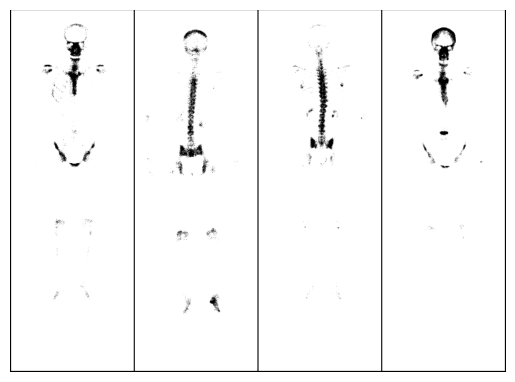

In [7]:
# Show random images from training data and their ground truth classes
dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Classes: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))

### Define Model

In [8]:
# Create model with CNN and MLP for classification
class CustomModel(nn.Module):
    
    # Define layers
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 1 * 158 * 52, out_features = 200)
        self.fc2 = nn.Linear(in_features = 200, out_features = 100)
        self.fc3 = nn.Linear(in_features = 100, out_features = 2)

    # Apply layers
    def forward(self, x):
        # CNN layers for convoltion
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(F.relu(self.conv(x)))
        # Flatten all dimensions except batch
        x = torch.flatten(input = x, start_dim = 1)
        # MLP layers for classification
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(input = x, dim = 1)
        return x

In [9]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

Performing torch operations on cpu device


In [10]:
# Instantiate model
model = CustomModel()

In [11]:
# Inspect model shapes per layer
summary(model, (1, 646, 220))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 1, 642, 216]              26
         MaxPool2d-2          [-1, 1, 321, 108]               0
            Conv2d-3          [-1, 1, 317, 104]              26
         MaxPool2d-4           [-1, 1, 158, 52]               0
            Linear-5                  [-1, 200]       1,643,400
            Linear-6                  [-1, 100]          20,100
            Linear-7                    [-1, 2]             202
Total params: 1,663,754
Trainable params: 1,663,754
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.54
Forward/backward pass size (MB): 1.64
Params size (MB): 6.35
Estimated Total Size (MB): 8.53
----------------------------------------------------------------


In [12]:
# Define criterion (function used to compute loss) and optimizer for model
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Train Model

In [13]:
epochs = 100
losses = []

In [14]:
# Train model
for epoch in range(epochs):
    print(f"Epoch: {epoch}/{epochs-1}")
    running_loss = 0
    batch_count = 0
    
    for batch_index, batch_data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [images, labels]
        images, labels = batch_data

        # Forward pass
        predictions = model(images) # Pass input through model.forward()
        loss = criterion(predictions, labels) # Compute loss against ground truth labels
        
        # Backpropagation
        optimizer.zero_grad() # Reset gradients from previous passes
        loss.backward() # Compute gradients using derivative of loss
        optimizer.step() # Update values using gradients

        running_loss += loss.item() # Add batch loss to current epoch loss
        batch_count += 1 # Increment number of finished batches
    
    running_loss = running_loss / batch_count
    losses.append(running_loss)
    print("Loss: {}".format(running_loss))
    print("------------------")

Epoch: 0/99
Loss: 0.6931471824645996
------------------
Epoch: 1/99
Loss: 0.6931471824645996
------------------
Epoch: 2/99
Loss: 0.6931471824645996
------------------
Epoch: 3/99
Loss: 0.6931471824645996
------------------
Epoch: 4/99
Loss: 0.6931471824645996
------------------
Epoch: 5/99
Loss: 0.6931471824645996
------------------
Epoch: 6/99
Loss: 0.6931471824645996
------------------
Epoch: 7/99
Loss: 0.6931471824645996
------------------
Epoch: 8/99
Loss: 0.6931471824645996
------------------
Epoch: 9/99
Loss: 0.6931471824645996
------------------
Epoch: 10/99
Loss: 0.6931471824645996
------------------
Epoch: 11/99
Loss: 0.6931471824645996
------------------
Epoch: 12/99
Loss: 0.6931471824645996
------------------
Epoch: 13/99
Loss: 0.6931471824645996
------------------
Epoch: 14/99
Loss: 0.6931471824645996
------------------
Epoch: 15/99
Loss: 0.6931471824645996
------------------
Epoch: 16/99
Loss: 0.6931471824645996
------------------
Epoch: 17/99
Loss: 0.6931471824645996
---

### Evaluate Model

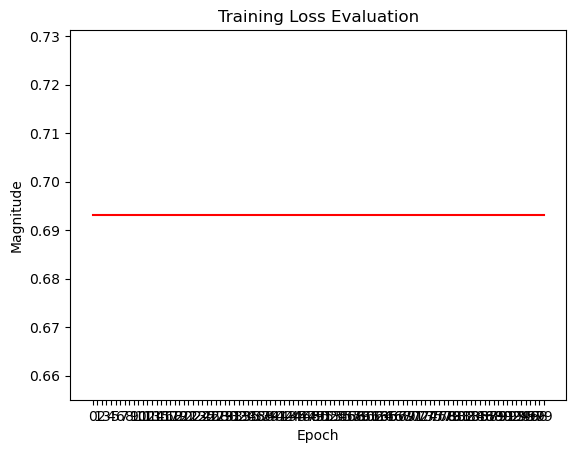

In [15]:
# Plot losses
ax = plt.axes()
plt.plot(losses, color='red')
plt.title('Training Loss Evaluation')
ax.set_xticks([x for x in range(epochs)])
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.show()

### Test Model on Test Dataset

In [16]:
# Dataset and dataloader for test data
testset = CustomDataset(img_dir=r"dataset-sample\test", transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Classes: 1 0 1 1


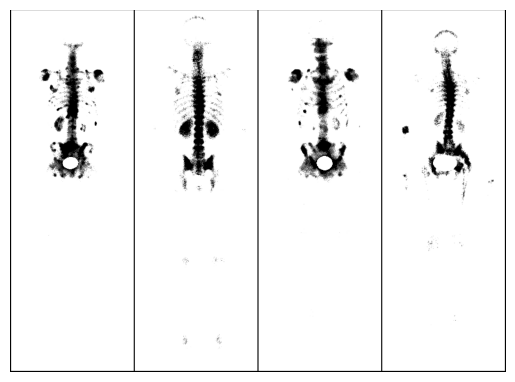

In [17]:
# Show sample images from test data and their ground truth classes
dataiter = iter(testloader)
images, labels = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Actual Classes: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))

In [18]:
correct_predictions = 0
total_predictions = 0

print("Model predictions on test dataset:")

with torch.no_grad(): # Without updating gradients
    for data in testloader:
        images, labels = data
        outputs = model(images) # Pass input through model.forward()
        
        # Choose class with the highest probability as the prediction for that image
        _, predicted = torch.max(input = outputs.data, dim = 1)
        
        for index in range(predicted.size(dim=0)):
            print(f"Predictions: {outputs[index]}")
            print(f"Actual Class: {labels[index]}   Predicted Class: {predicted[index]}\n")
        
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

print(f'Model accuracy on {total_predictions} test images: {100 * correct_predictions // total_predictions}%')

Model predictions on test dataset:
Predictions: tensor([0.5000, 0.5000])
Actual Class: 1   Predicted Class: 0

Predictions: tensor([0.5000, 0.5000])
Actual Class: 0   Predicted Class: 0

Predictions: tensor([0.5000, 0.5000])
Actual Class: 1   Predicted Class: 0

Predictions: tensor([0.5000, 0.5000])
Actual Class: 0   Predicted Class: 0

Predictions: tensor([0.5000, 0.5000])
Actual Class: 1   Predicted Class: 0

Model accuracy on 5 test images: 40%
